In [22]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb                 # If error: pip install seaborn in terminal

In [134]:
path = '../../TreeTect/data/trainings_data_waterbodies/data_non_acomp_all_polygons_2020-03-12 15:00:12.430987.csv'

nr_search = path.split('/')[-1].split('_')[4]

nr_search


# Reading the raw data into a Pandas DataFrame

import pandas as pd

data_raw = pd.read_csv(path).drop('Unnamed: 0', axis = 1).drop(['x','y'], axis= 1)

# First we rename the columns of our dataset 

    # select variables
property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

data_raw.columns = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names  + ['label']

# Here we will calculate the indices with the band data we already have

data_raw['ndvi'] = (data_raw.nir1 - data_raw.red)/(data_raw.nir1 + data_raw.red)
data_raw['ndwi'] = (data_raw.green - data_raw.nir1)/(data_raw.green + data_raw.nir1)

data_raw['wwi'] = (data_raw.coastal-data_raw.nir2)/(data_raw.coastal+data_raw.nir2+10e-5)

data_clean = data_raw


all_variables = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names + ['ndvi','ndwi', 'wwi']

i = 0 
for variable in all_variables:
    print(i, variable)
    i = i + 1
    
variable_selection = [0,4,16,17]

all_variables = [all_variables[i] for i in variable_selection]


0 coastal
1 blue
2 green
3 yellow
4 red
5 red_edge
6 nir1
7 nir2
8 cloudCover
9 multiResolution
10 targetAzimuth
11 sunAzimuth
12 offNadirAngle
13 sunElevation
14 panResolution
15 ndvi
16 ndwi
17 wwi


In [135]:
len(all_variables)

4

In [136]:
X = data_clean[all_variables].values

# Similarly, we can extract the labels
y = data_clean['label'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the label in all_labels[5]

# Here's what a subset of our inputs looks like:
X[:5]


array([[ 1.61500000e+03,  9.44000000e+02,  1.86046512e-01,
         4.52338109e-01],
       [ 1.76800000e+03,  1.28100000e+03,  4.80584391e-02,
         3.18419078e-01],
       [ 1.86900000e+03,  1.42900000e+03, -4.95399858e-03,
         2.72727263e-01],
       [ 1.72500000e+03,  1.57900000e+03, -2.15169002e-01,
        -3.79252639e-02],
       [ 1.70600000e+03,  8.30000000e+02, -3.77823942e-01,
        -9.54400823e-02]])

In [137]:
# We need to make sure that no variables are strings, so we need to transform 
# !pip install sklearn

# Import LabelEncoder
from sklearn import preprocessing # 

# Creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
y_encoded=le.fit_transform(y)


In [138]:
# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split          # If error pip install sklearn in terminal

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y_encoded, test_size=0.25, random_state=1)

**Parameter tuning**
Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

**Random forest classifier**

In [139]:
# Fit random forest classifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [25, 50, 100],
                  'criterion': ['entropy'],
                  'max_features': [4, 8]}

cross_validation = StratifiedKFold(n_splits=10)

rf_grid_search = GridSearchCV(  random_forest_classifier,
                                param_grid=parameter_grid,
                                cv=cross_validation,                                 
                                n_jobs=4,
                                verbose=8
                             )

rf_grid_search.fit(X, y)
print('Best score random forest classifier: {}'.format(rf_grid_search.best_score_))
print('Best parameters random forest classifier: {}'.format(rf_grid_search.best_params_))

rf_grid_search.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 11.6min finished


Best score random forest classifier: 0.7982534830217229
Best parameters random forest classifier: {'criterion': 'entropy', 'max_features': 4, 'n_estimators': 150}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [140]:
# Classification report random forest classifier

from sklearn.metrics import classification_report

y_pred = rf_grid_search.predict(X_test)
print(classification_report(y_test, y_pred == 'water'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25813
           1       1.00      1.00      1.00     18795

    accuracy                           1.00     44608
   macro avg       1.00      1.00      1.00     44608
weighted avg       1.00      1.00      1.00     44608



In [141]:
rf_grid_search.param_grid['n_estimators']

[100, 150]

''

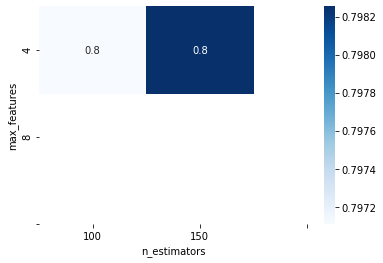

In [142]:
import numpy as np

dt_grid_visualization = rf_grid_search.cv_results_['mean_test_score'][0:9]
dt_grid_visualization.shape = (2, 2)
sb.heatmap(dt_grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(3) + 0.5, rf_grid_search.param_grid['n_estimators'])
plt.yticks(np.arange(3) + 0.5, rf_grid_search.param_grid['max_features'])
plt.xlabel('n_estimators')
plt.ylabel('max_features')
;

**Step 7: Classification**

In this part we'll use the classifier with the highest accuracy to classify our satellite image. 

# load image from file

In [143]:
import glob
from pprint import pprint


nr_search = '000'

# find files in shapefile folder
shape_file_path = '../../TreeTect/data/rasters_waterbodies_osm/**/*.tif'.format(nr_search)
raster_files = glob.glob(shape_file_path)
file_path = raster_files[10]

print('-------------------------------------')
pprint(raster_files[0:10])
print('-------------------------------------')
print(file_path)

-------------------------------------
['../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_052_pansharpen_True_2019-08-01_02:45_1030010096902A00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_033_pansharpen_True_2019-08-12_02:39_1030010097468D00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_041_pansharpen_True_2019-08-01_02:45_1030010096902A00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_048_pansharpen_True_2019-08-12_02:39_1030010097468D00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_023_pansharpen_True_2019-08-12_02:39_1030010097468D00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_042_pansharpen_True_2019-08-01_02:45_1030010096902A00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_036_pansharpen_True_2019-08-01_02:45_1030010096902A00.tif',
 '../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_028_pansharpen_True_2019-08-12

In [144]:
for file_path in np.array(pd.DataFrame(raster_files).sample(5)).flatten(): 
    print(file_path)

../../TreeTect/data/rasters_waterbodies_osm/Medan/Medan_260_pansharpen_True_2020-03-03_04:05_10300100A367E500.tif
../../TreeTect/data/rasters_waterbodies_osm/Denpasar/Denpasar_050_pansharpen_True_2019-08-12_02:39_1030010097468D00.tif
../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_000_pansharpen_True_2019-07-23_03:16_1030010096702700.tif
../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_528_pansharpen_True_2018-04-03_03:22_103001007C082C00.tif
../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_133_pansharpen_True_2018-04-03_03:22_103001007C082C00.tif


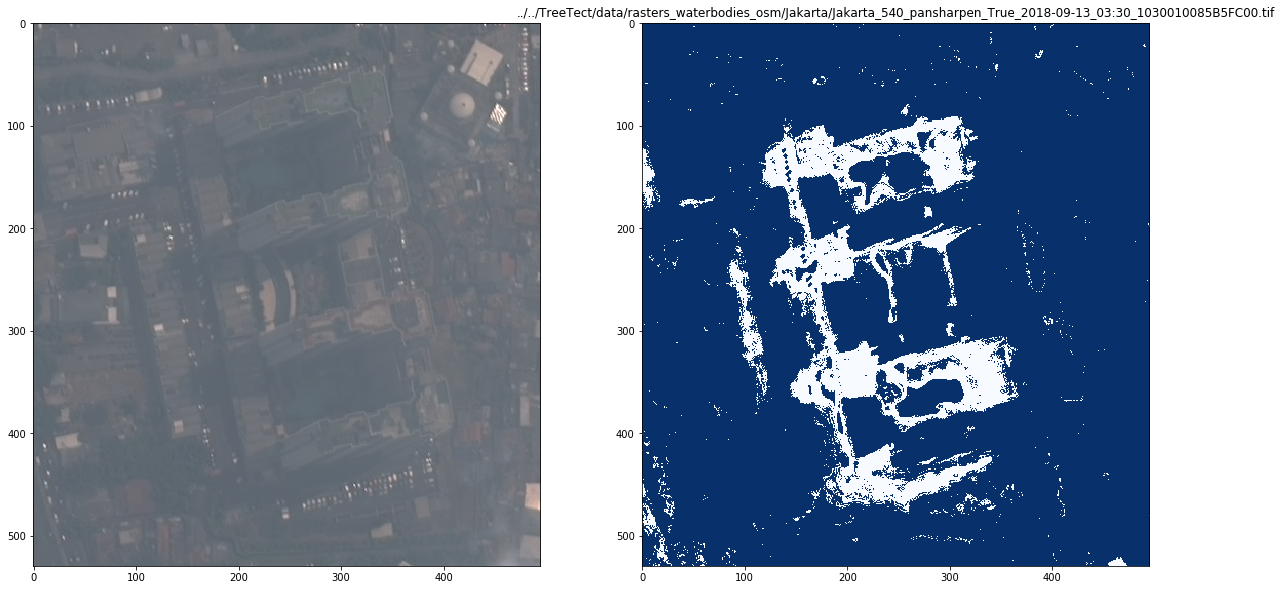

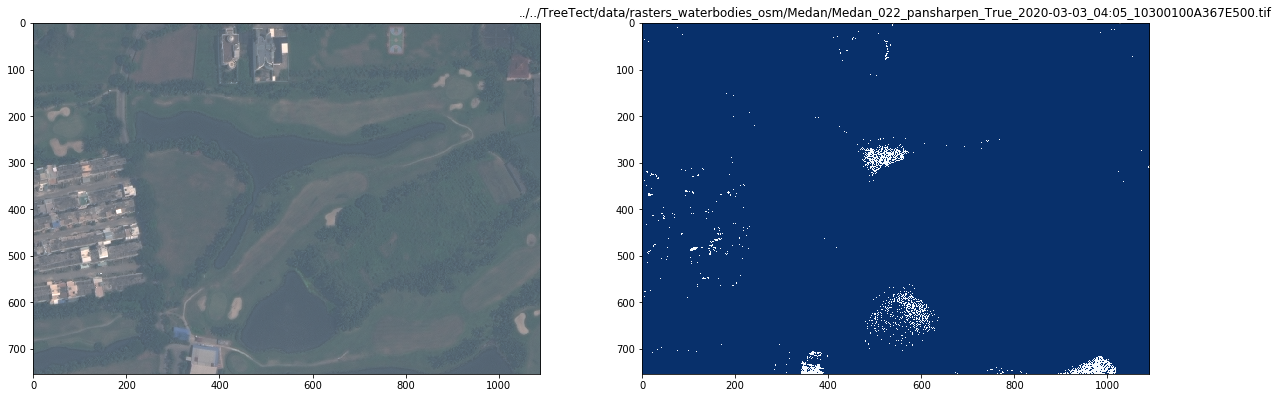

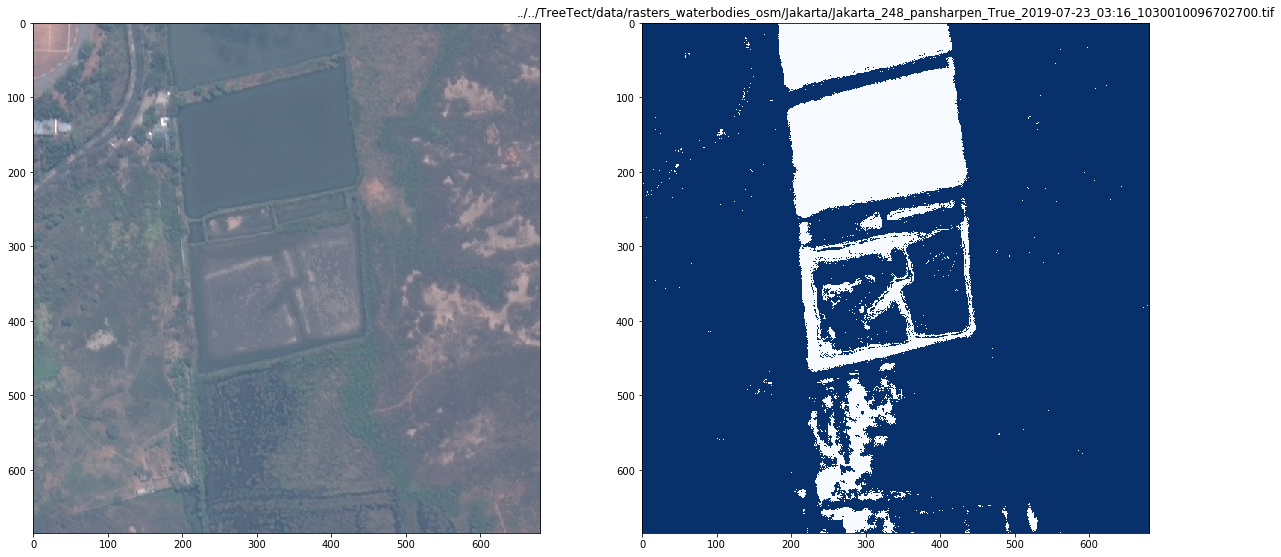

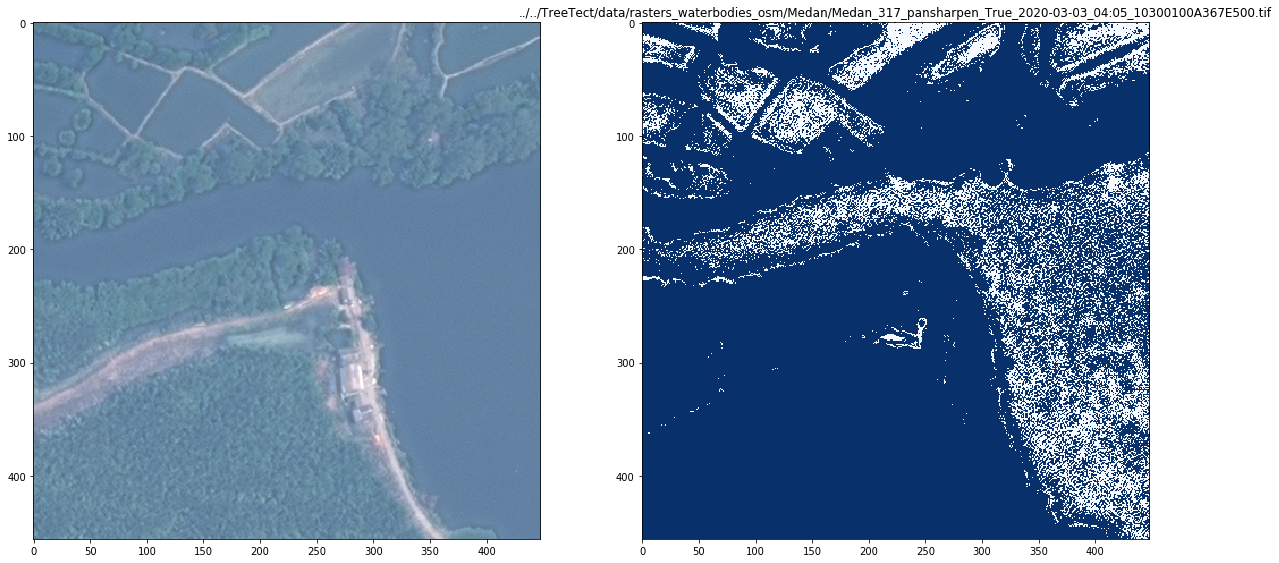

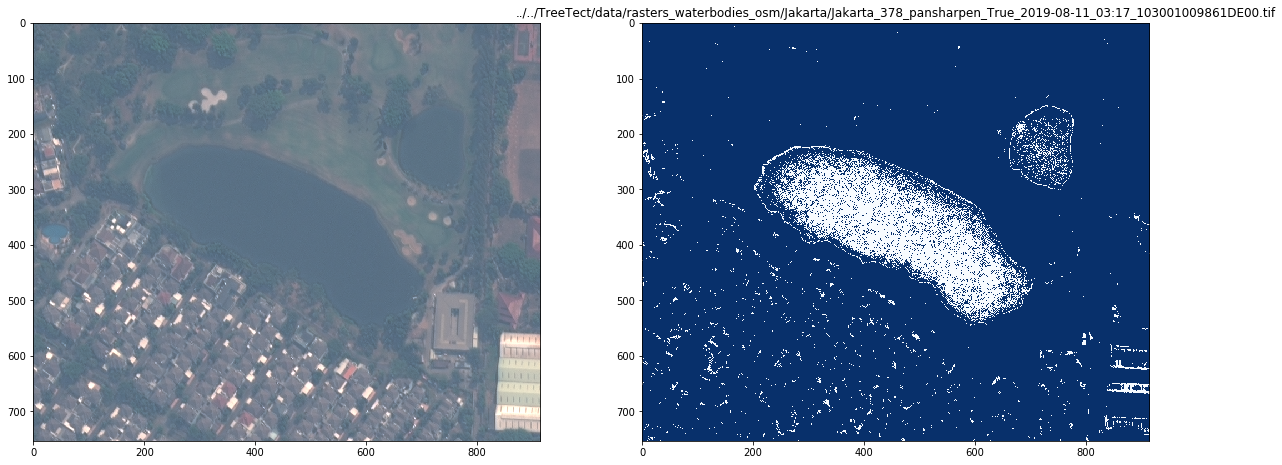

In [146]:
# get metadata from gbdx
from gbdxtools import Interface
gbdx = Interface()

from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
import matplotlib.pyplot as plt


# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

    
# Bands
# coastal = data[0]
# blue = data[1]
# green = data[2]
# yellow = data[3]
# red = data[4]
# red_edge = data[5]
# nir1 = data[6]
# nir2 = data[7]

for file_path in np.array(pd.DataFrame(raster_files).sample(5)).flatten(): 

    import rasterio

    data = rasterio.open(file_path).read()
    dataset = rasterio.open(file_path)

    transform = dataset.meta['transform']
    width = dataset.meta['width']
    height = dataset.meta['height']

    # Split image data into band layers
    blocksize = 1
    
    coastal = threshold_local(data[0], blocksize, offset=0) 
    blue    = threshold_local(data[1], blocksize, offset=0) 
    green   = threshold_local(data[2], blocksize, offset=0) 
    yellow  = threshold_local(data[3], blocksize, offset=0)
    red     = threshold_local(data[4], blocksize, offset=0) 
    red_edge = threshold_local(data[5], blocksize, offset=0) 
    nir1 = threshold_local(data[6], blocksize, offset=0)
    nir2 = threshold_local(data[7], blocksize, offset=0) 

    # get info from filenames
    stringlist = file_path.split('/')[-1].split('_')
    image_id = stringlist[-1].split('.')[0]

    record = gbdx.catalog.get(image_id)

    i = 8

    for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]  

                property_array = np.empty([1,data.shape[1],data.shape[2]])
                property_array.fill(property_record)

                data = np.vstack([data,property_array])
            except: 
                print('failed ', property_name, image_id)
                property_array = np.empty([1,data.shape[1],data.shape[2]])
                data = np.vstack([data,property_array])

            i = i + 1

    


    # Calculate indices
    # Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
    ndvi = reshape((nir1 - red)/(nir1 + red))
    ndwi = reshape((green - nir1) / (green + nir1))
    wwi = reshape((coastal - nir2) / (coastal + nir2 + 10e-5))

    # Stack arrays in sequence vertically (row wise)
    image_array = np.vstack([data,ndvi,ndwi, wwi])
    
    image_array = image_array[variable_selection,:,:]

    # Calculate 3-dimensional shape of new image_array
    n_bands, rows, cols = image_array.shape

    # Calculate number of pixels/samples
    n_samples = rows*cols

    # Create table where every row represents the data in one pixel/sample
    reshaped_data = image_array.reshape(n_bands,(rows*cols))

    #Remove NAN values
    reshaped_data[np.isnan(reshaped_data)] = 0

    # Predict class of image
    result = rf_grid_search.predict(reshaped_data.T)
    classification = result.T.T.T.reshape((rows, cols))

    # Get classnames and corresponding indices
    classnames, indices = np.unique(classification, return_inverse=True)
    classification_plot = indices.reshape((rows, cols))
    bands, x, y = data.shape

    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    rgb[rgb > 255] = 254

    # plotting
    f = plt.figure( figsize = (20,20))
    f.add_subplot(1, 2, 1)
    plt.imshow(rgb)
    f.add_subplot(1, 2, 2)
    im = plt.imshow(classification_plot, cmap = 'Blues')
    plt.title(file_path)
    
    plt.show()

# Check images

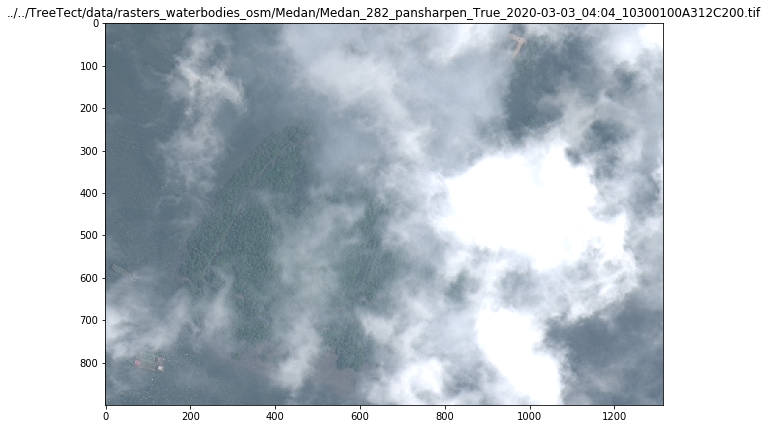

remove? y/ny


In [115]:
import os
import rasterio
from IPython.display import clear_output

def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    rgb[rgb > 255] = 254
    
    return rgb


destination_path = '../../TreeTect/data/rasters_waterbodies_osm/bad_quality_files'
    

for file_path in raster_files: #np.array(pd.DataFrame(raster_files).sample(5)).flatten(): 

    clear_output(wait = True)
    # load raster
    data = rasterio.open(file_path).read()
    dataset = rasterio.open(file_path)    
        
    rgb = rgb_from_raster(data, 0.2)
    
    # plotting
    f = plt.figure( figsize = (10,10))
    f.add_subplot(1, 1, 1)
    plt.imshow(rgb)
    plt.title(file_path)
    
    plt.show()
    
    remove_bool = input('remove? y/n')
    
    if remove_bool == 'y':
        
        command = 'mv {} {}'.format(file_path, destination_path)
        import os
        os.system(command)
    else:
        print('not moved')
        
        continue

In [93]:
n

(8, 2507, 3809)

In [91]:
file_path

'../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_335_pansharpen_True_2019-08-11_03:17_103001009861DE00.tif'

# SVM

In [180]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]} ] #,
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), 
        tuned_parameters, 
        scoring='%s_macro' % score,
        n_jobs=4,
        verbose=8
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   26.4s finished


Best parameters set found on development set:

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.983 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.962 (+/-0.046) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.983 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.965 (+/-0.031) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.983 (+/-0.002) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.965 (+/-0.031) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.983 (+/-0.002) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.965 (+/-0.031) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      0.26      0.41       117
           1       0.96      1.00      0.98      2383

    accuracy                           0.97      2500
  

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   24.4s finished


Best parameters set found on development set:

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.630 (+/-0.047) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.678 (+/-0.031) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.630 (+/-0.047) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.721 (+/-0.016) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.630 (+/-0.047) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.721 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.630 (+/-0.047) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.721 (+/-0.016) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.97      0.49      0.65       117
           1       0.98      1.00      0.99      2383

    accuracy                           0.98      2500


# get image from GBDX

In [ ]:
bbox = [115.179, -8.734, 115.183, -8.729 ]

x_min = bbox[0]
x_max = bbox[2]
y_min = bbox[1]
y_max = bbox[3]


file_name = 'Denpasar.tif'

In [ ]:
# Import image

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline



catalog_id = env.inputs.get('catalog_id', '104001005876CA00')






# get a projected coordinate system for plotting
EPSG = 32700-round((45+list(bbox)[1])/90,0)*100+round((183+list(bbox)[0])/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)

# image = CatalogImage(catalog_id, band_type="MS", bbox=bbox, proj = UTM_EPSG_code, pansharpen = True, acomp=False)

# acquisitionDate = image.metadata["image"]["acquisitionDate"]

# print("  taken on {}".format(acquisitionDate))


# image.plot(w=10, h=10)

# # Transform dask array to array
# image_array = image.read()m
# data = image_array

In [211]:
import itertools

# Shapely and Rasterio for processing geometries
from shapely import geometry
from shapely.geometry import box, shape, Polygon
from shapely.ops import cascaded_union
from rasterio import features   

# GBDX
from gbdxtools import Interface

# array operations and plotting
import numpy as np
import matplotlib.pyplot as plt

# scikit-image modules for image science operators
from skimage import filters, morphology

# Initialize gbdx interface
# gbdx = Interface()

# if is(image):
#     rgb = image.rgb()

In [212]:

# classification_plot[classification_plot == 1] = 0
# classification_plot[classification_plot == 2] = 1

In [221]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 8000.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

8000.0 sq. m
50000 grid cells


In [222]:
# First, remove the small holes
water_cleaned = morphology.remove_small_holes(classification_plot, min_feature_size_cells / 4)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  


In [223]:
# Also extract the visible color (i.e., Red-Green-Blue) 
# bands, which we'll use for side-by-side plotting as we proceed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cleaned Water Mask')

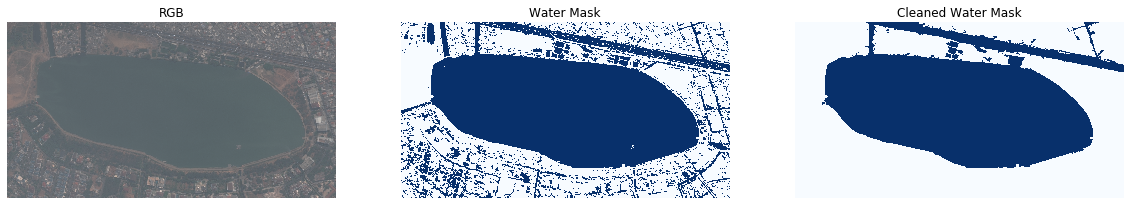

In [224]:
# View the results
plt.figure(figsize=(20,15))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(classification_plot, vmin=0, vmax=1, cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

In [225]:
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = [g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 


In [226]:
sum(sum(water_cleaned))

1371300

In [227]:
try: 
    affine = image.affine
except:
    affine = dataset.meta['transform']

In [228]:
affine

Affine(4.590370104204096e-06, 0.0, 106.862583220424,
       0.0, -4.590370104204096e-06, -6.123154339396335)

In [229]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(0.001) for g in water_lines]
    
# # Finally, take a look at them on a slippy map
# c = gbdx.vectors.map([{'geometry':x.__geo_interface__} for x in water_lines_smooth])

In [230]:
# GLue it all together
setu = cascaded_union(water_lines)


# # Finally, take a look at them on a slippy map
# c = gbdx.vectors.map([{'geometry':u.__geo_interface__}])

In [231]:
from shapely import geometry, ops

setu = ops.linemerge(setu)

In [232]:
len(setu)

405

In [233]:
import pyproj
from shapely.ops import transform
from functools import partial



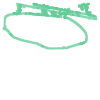

In [234]:
setu

In [235]:
s = setu.simplify(0.00001, preserve_topology=False)

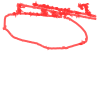

In [236]:
s

In [237]:
import folium

In [238]:
bbox_list_str = bbox

NameError: name 'bbox' is not defined

In [ ]:
bbox = [float(bbox_list_str[0]),float(bbox_list_str[1]),float(bbox_list_str[2]),float(bbox_list_str[3])]
trees = classification_plot == 2

In [239]:
from shapely.ops import transform
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:32750'),
    pyproj.Proj(init='epsg:4326'))



setu_wgs = transform(project, setu)


setu_smooth = setu_wgs.simplify(0.00003)
setu_poly = ops.polygonize_full(setu_wgs)[0]

In [240]:
setu_smooth_utm = setu.simplify(8)

In [241]:
affine

Affine(4.590370104204096e-06, 0.0, 106.862583220424,
       0.0, -4.590370104204096e-06, -6.123154339396335)

In [242]:
(affine[0] + affine[4])/2

0.0

In [244]:
m = folium.Map([s.centroid.y, s.centroid.x],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


# folium.Choropleth(setu_wgs, name = 'Setu water delineation').add_to(m)

folium.Choropleth(setu_poly, name = 'exterior').add_to(m)

folium.Choropleth(setu, name = 'hallo').add_to(m)

# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=df['ActualDBH'][point], group  = "Tree removals").add_to(m)

folium.LayerControl().add_to(m)

In [245]:
m

In [887]:
shape_filename = file_path.split('/')[-1].split('.')[0]

In [1000]:
setu = Multi

In [1008]:
Multi

AttributeError: 'Polygon' object has no attribute 'ring'

In [1003]:
from shapely.geometry import mapping, Polygon, LineString, MultiLineString
import fiona

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'LineString',
    'properties': {'id': 'int'},
}


filename = '../../TreeTect/data/shapefiles_waterbodies_osm/Shape_{}.shp'.format(shape_filename)


# Write a new Shapefile
with fiona.open(filename, 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    try: 
        for poly in setu:
            c.write({
                'geometry': mapping(poly),
                'properties': {'id': 123},
            })
    except:
        c.write({
                'geometry': mapping(setu),
                'properties': {'id': 123},
            })
        
    print('shapefile created ' + filename)

TypeError: 'Polygon' object is not subscriptable

In [890]:
# load libraries
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.geometry import shape

import fiona

In [994]:
# load polygons
path = filename
shape_crs = fiona.open(path)
Multi = MultiLineString([shape(pol['geometry']) for pol in fiona.open(path)]) 

min_x, min_y, max_x, max_y = Multi.bounds

Multi = Multi.convex_hull

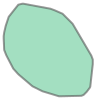

In [997]:
Multi

In [995]:
filename

'../../TreeTect/data/shapefiles_waterbodies_osm/Shape_Jakarta_003_pansharpen_True_2018-09-13_03:30_1030010085B5FC00.shp'

In [977]:
Multi = Multi.exterior

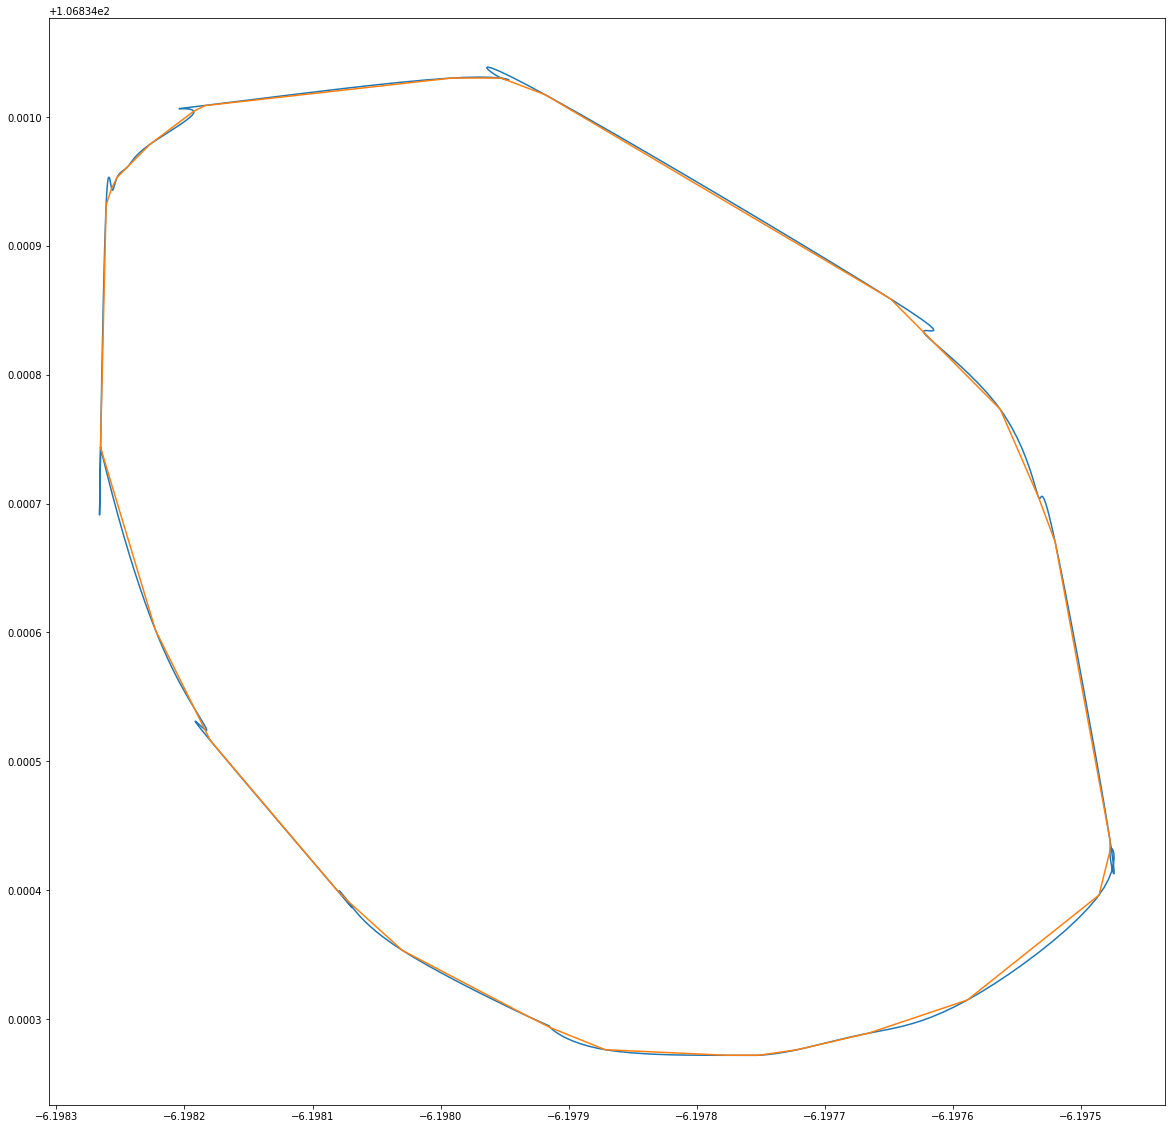

In [980]:
import scipy.interpolate as si


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

x = np.array(Multi.coords[:])[:,1]
y = np.array(Multi.coords[:])[:,0]

t = np.arange(len(x))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, x, kind='cubic')(ti)
yi = interp1d(t, y, kind='cubic')(ti)

fig, ax = plt.subplots(figsize = (20,20))
ax.plot(xi, yi)
ax.plot(x, y)
ax.margins(0.05)
plt.show()

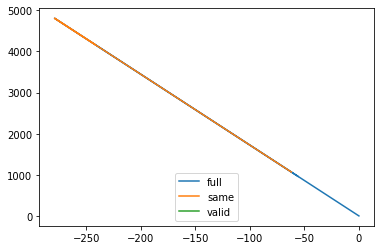

In [958]:
import numpy as np
import matplotlib.pyplot as plt
modes = ['full', 'same', 'valid']
for m in modes:
    plt.plot(np.convolve(x, np.linspace(0, len(x) - 1, len(x)), mode=m), 
             np.convolve(y, np.linspace(0, len(y) - 1, len(x)), mode=m));
    
    
    
plt.plot(x,y)    

plt.legend(modes, loc='lower center');
plt.show()

In [954]:
np.linspace(0, 9, 10)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

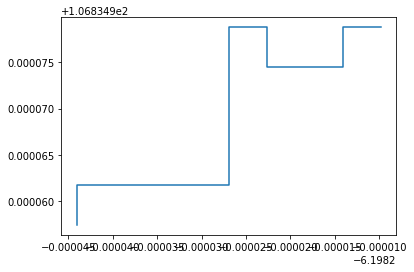

In [959]:
plt.plot(x,y) 

In [962]:
np.convolve(np.linspace(0, len(x) - 1, len(x)), x, mode=m)

array([-278.91983522])

In [6]:
np.convolve(y, np.linspace(0, len(y) - 1, len(x)), mode=m)

NameError: name 'y' is not defined